# Model Evaluation

This notebook evaluates the final trained model on the test set.

**Pipeline:**
- Load the trained model from `2_TrainBestModel.ipynb`
- Evaluate on test set
- Generate comprehensive evaluation metrics
- Create visualizations

# Imports

In [91]:
import numpy as np

import matplotlib.pyplot as plt

from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, precision_score, ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay

from astroML.classification import GMMBayes
from astroML.datasets import fetch_rrlyrae_combined
from astroML.utils import split_samples

from scipy.stats import norm


from astropy.io import ascii
from astropy.io import fits
import os.path

from astropy.table import Table, join, MaskedColumn, vstack, Column


import numpy as np
from astropy.table import vstack
import torch

import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelEncoder, StandardScaler



import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import numpy as np
from torch.distributions.normal import Normal
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from sklearn.model_selection import ParameterGrid
import math
import copy
import warnings

from itertools import cycle

# Setup Paths

In [92]:
# Import paths from pipeline_config for multi-machine portability
from pipeline_config import config, project_dir_path, pipeline_dir_path, temp_files_path, device

# Dataset configuration
dataset_name = 'traintest_data5_v2.pkl'

# Load Dataset

In [93]:
# ============================================================
# LOAD DATASET
# ============================================================

import pickle

print("Loading dataset...")
save_path = temp_files_path
file_name = dataset_name

with open(save_path + file_name, 'rb') as f:
    PROCESSED_DATASET = pickle.load(f)

(   X_train, X_test, 
    period_train, period_test, 
    y_train, y_test, 
    feature_cols,
    train_cluster_names, test_cluster_names) = PROCESSED_DATASET

print("\n" + "="*70)
print("DATASET LOADED")
print("="*70)
print(f"Training set:   {X_train.shape[0]} samples")
print(f"Test set:       {X_test.shape[0]} samples")
print(f"Features:       {X_train.shape[1]} summary statistics")
print(f"Periodogram:    {period_train.shape[1]} frequency bins")
print(f"\nTrain clusters: {len(np.unique(train_cluster_names))} unique clusters")
print(f"Test clusters:  {len(np.unique(test_cluster_names))} unique clusters")
print("\n⚠️  NOTE: Data is RAW (unscaled). We'll use preprocessed data from model package.")
print("="*70)

Loading dataset...

DATASET LOADED
Training set:   3154 samples
Test set:       516 samples
Features:       16 summary statistics
Periodogram:    1089 frequency bins

Train clusters: 272 unique clusters
Test clusters:  35 unique clusters

⚠️  NOTE: Data is RAW (unscaled). We'll use preprocessed data from model package.


# Load Model Architecture and Helper Functions

In [94]:
# Load model class definition
import sys
sys.path.append(project_dir_path)

from GaussianNN_wPeriodogram import DualInputNN

In [95]:
# Enable autoreload - automatically reloads modules when they change
%load_ext autoreload
%autoreload 2 

# Import evaluation functions
from DataAnalysis_HelperFcns import (
    mae, rmse, coverage, crps_gaussian, Loss_Components
)

from SingleFold_PlottingFcns import (
    SummaryStats, PlotSummaryStats
)

# Import NEW model evaluation plotting functions
from ModelEvaluation_PlottingFcns import (
    # Core Performance Plots
    plot_prediction_vs_truth,
    plot_residuals_analysis,
    plot_residuals_simple,
    # Summary Metrics
    compute_summary_metrics,
    print_metrics_table,
    plot_metrics_comparison,
    # Uncertainty Calibration Plots
    plot_zscore_analysis,
    plot_coverage_calibration,
    plot_uncertainty_distribution
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Trained Model

In [96]:
# ============================================================
# LOAD TRAINED MODEL
# ============================================================

model_path = temp_files_path + 'final_model.pt'

print("Loading trained model...")
model_package = torch.load(model_path)

# Extract model components
hyperparameters = model_package['hyperparameters']
model_architecture = model_package['model_architecture']
training_log = model_package['training_log']
best_epoch = model_package['best_epoch_from_tuning']
composite_score = model_package['composite_score']

# Check if we have best_model_epoch info
best_model_epoch = model_package.get('best_model_epoch', None)

# Display model information
print("\n" + "="*70)
print("TRAINED MODEL LOADED")
print("="*70)
print(f"Best epoch (from tuning): {best_epoch}")
print(f"Composite score:          {composite_score:.4f}")

if best_model_epoch is not None:
    print(f"\n💡 This model is from epoch {best_model_epoch} (best smoothed val loss)")

print(f"\nModel Architecture:")
print(f"  Summary stats dim:      {model_architecture['summary_dim']}")
print(f"  Periodogram dim:        {model_architecture['periodogram_dim']}")
print(f"  Hidden layer size:      {model_architecture['hidden_size']}")
print(f"  Dropout probability:    {model_architecture['dropout_prob']}")
print(f"  Use periodogram:        {model_architecture['use_periodogram']}")
print(f"  Use CNN:                {model_architecture['use_cnn']}")
print(f"  Learn sigma:            {model_architecture['learn_sigma']}")
print("\nHyperparameters:")
for key, value in hyperparameters.items():
    print(f"  {key:30s} = {value}")
print("="*70)

Loading trained model...

TRAINED MODEL LOADED
Best epoch (from tuning): 12
Composite score:          0.3419

💡 This model is from epoch 8 (best smoothed val loss)

Model Architecture:
  Summary stats dim:      16
  Periodogram dim:        1089
  Hidden layer size:      16
  Dropout probability:    0.1
  Use periodogram:        True
  Use CNN:                False
  Learn sigma:            True

Hyperparameters:
  Layer1_Size                    = 16
  Layer2_Size                    = 8
  Optimizer                      = AdamW
  WarmUp_Epochs                  = 5
  artificial_loss_weight_factor  = 1
  batch_size                     = 4
  decoupled                      = False
  dropout_prob                   = 0.1
  learn_sigma                    = True
  lr                             = 0.0001
  n_epochs                       = 25
  n_layers                       = 2
  num_kfolds                     = 1
  oversample_bins                = 10
  oversample_uniform             = True
  use

/tmp/ipykernel_1894150/629542784.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_package = torch.load(model_path)


# Reconstruct Model from Saved Weights

In [97]:
# ============================================================
# RECONSTRUCT MODEL
# ============================================================

print("Reconstructing model from saved weights...")

# Initialize model with saved architecture
final_model = DualInputNN(
    summary_dim=model_architecture['summary_dim'],
    periodogram_dim=model_architecture['periodogram_dim'],
    x1=model_architecture['hidden_size'],
    dropout_prob=model_architecture['dropout_prob'],
    use_periodogram=model_architecture['use_periodogram'],
    periodogram_use_cnn=model_architecture['use_cnn'],
    learn_sigma=model_architecture['learn_sigma']
)

# Load trained weights
final_model.load_state_dict(model_package['model_state_dict'])

# Set to evaluation mode
final_model.eval()

print("\n✅ Model reconstructed and ready for evaluation!")
print(f"   Model is in evaluation mode (dropout disabled)")
print("="*70)

Reconstructing model from saved weights...

✅ Model reconstructed and ready for evaluation!
   Model is in evaluation mode (dropout disabled)


# Apply Preprocessing from Saved Model

In [98]:
# ============================================================
# APPLY PREPROCESSING FROM MODEL PACKAGE
# ============================================================

print("\n" + "="*70)
print("APPLYING PREPROCESSING")
print("="*70)

# Extract preprocessing objects from model package
SCALER = model_package['scaler']
y_mean = model_package['y_mean']
mean_peak_strength = model_package['mean_peak_strength']

print(f"\nPreprocessing parameters from trained model:")
print(f"  y_mean (target mean):              {y_mean:.4f}")
print(f"  mean_peak_strength (periodogram):  {mean_peak_strength:.6f}")
print(f"  Scaler mean (first 3 features):    {SCALER.mean_[:3]}")

# Apply preprocessing to training data
print("\nPreprocessing TRAINING data...")
X_train_scaled = torch.tensor(
    SCALER.transform(X_train.cpu().numpy()),
    dtype=torch.float32
)
y_train_demeaned = y_train - y_mean
period_train_norm = period_train / mean_peak_strength

# Apply preprocessing to test data
print("Preprocessing TEST data...")
X_test_scaled = torch.tensor(
    SCALER.transform(X_test.cpu().numpy()),
    dtype=torch.float32
)
y_test_demeaned = y_test - y_mean
period_test_norm = period_test / mean_peak_strength

print("\n✅ Preprocessing complete!")
print(f"   Train X range: [{X_train_scaled.min():.3f}, {X_train_scaled.max():.3f}]")
print(f"   Test X range:  [{X_test_scaled.min():.3f}, {X_test_scaled.max():.3f}]")
print(f"   Train y range: [{y_train_demeaned.min():.3f}, {y_train_demeaned.max():.3f}]")
print(f"   Test y range:  [{y_test_demeaned.min():.3f}, {y_test_demeaned.max():.3f}]")
print("="*70)


APPLYING PREPROCESSING

Preprocessing parameters from trained model:
  y_mean (target mean):              7.9852
  mean_peak_strength (periodogram):  0.165972
  Scaler mean (first 3 features):    [0.10966317 0.00084907 0.00056291]

Preprocessing TRAINING data...
Preprocessing TEST data...

✅ Preprocessing complete!
   Train X range: [-1.649, 11.882]
   Test X range:  [-1.649, 105.660]
   Train y range: [-1.585, 2.065]
   Test y range:  [-1.375, 2.065]


# Generate Predictions on Train and Test Sets

In [99]:
# ============================================================
# GENERATE PREDICTIONS
# ============================================================

print("\n" + "="*70)
print("GENERATING PREDICTIONS")
print("="*70)

# Set model to evaluation mode (disable dropout)
final_model.eval()

with torch.no_grad():
    # Train set predictions (using SCALED/PREPROCESSED data)
    print("\nGenerating predictions on TRAINING set...")
    y_pred_train_demeaned, sigma_pred_train = final_model(X_train_scaled, period_train_norm)
    
    # Add back the mean to get predictions in original scale
    y_pred_train = y_pred_train_demeaned + y_mean
    
    print(f"  ✅ Train predictions: {y_pred_train.shape}")
    print(f"     Age range: [{y_pred_train.min():.3f}, {y_pred_train.max():.3f}]")
    print(f"     Sigma range: [{sigma_pred_train.min():.3f}, {sigma_pred_train.max():.3f}]")
    
    # Test set predictions (using SCALED/PREPROCESSED data)
    print("\nGenerating predictions on TEST set...")
    y_pred_test_demeaned, sigma_pred_test = final_model(X_test_scaled, period_test_norm)
    
    # Add back the mean to get predictions in original scale
    y_pred_test = y_pred_test_demeaned + y_mean
    
    print(f"  ✅ Test predictions: {y_pred_test.shape}")
    print(f"     Age range: [{y_pred_test.min():.3f}, {y_pred_test.max():.3f}]")
    print(f"     Sigma range: [{sigma_pred_test.min():.3f}, {sigma_pred_test.max():.3f}]")

print("\n" + "="*70)
print("✅ Predictions complete!")
print("  Note: Predictions have been converted back to original scale")
print("="*70)


GENERATING PREDICTIONS

Generating predictions on TRAINING set...
  ✅ Train predictions: torch.Size([3154, 1])
     Age range: [6.289, 11.687]
     Sigma range: [0.199, 2.805]

Generating predictions on TEST set...
  ✅ Test predictions: torch.Size([516, 1])
     Age range: [6.294, 11.355]
     Sigma range: [0.008, 3.707]

✅ Predictions complete!
  Note: Predictions have been converted back to original scale


# Compute Summary Metrics

In [100]:
# ============================================================
# COMPUTE SUMMARY METRICS
# ============================================================

print("Computing metrics...")

# Compute metrics for train and test sets
train_metrics = compute_summary_metrics(y_train, y_pred_train, sigma_pred_train)
test_metrics = compute_summary_metrics(y_test, y_pred_test, sigma_pred_test)

# Print comparison table
print_metrics_table(train_metrics, test_metrics)

Computing metrics...

MODEL EVALUATION METRICS SUMMARY
Metric                          Train Set        Test Set      Difference
--------------------------------------------------------------------------------
MAE                                0.5116          0.5079         -0.0037
RMSE                               0.6402          0.6890          0.0488
Median Error                       0.4298          0.3608         -0.0690
Max Error                          2.6215          3.3797          0.7582
Mean Residual                      0.2507          0.2427         -0.0080
Median Residual                    0.2708          0.2299         -0.0409
Coverage@68%                       0.7809          0.7984          0.0175
Coverage@95%                       0.9864          0.9593         -0.0271
Coverage@99%                       0.9968          0.9787         -0.0181
CRPS                               0.3671          0.3811          0.0140
Mean Sigma                         0.8154         

# Visualization: Metrics Comparison Bar Plot

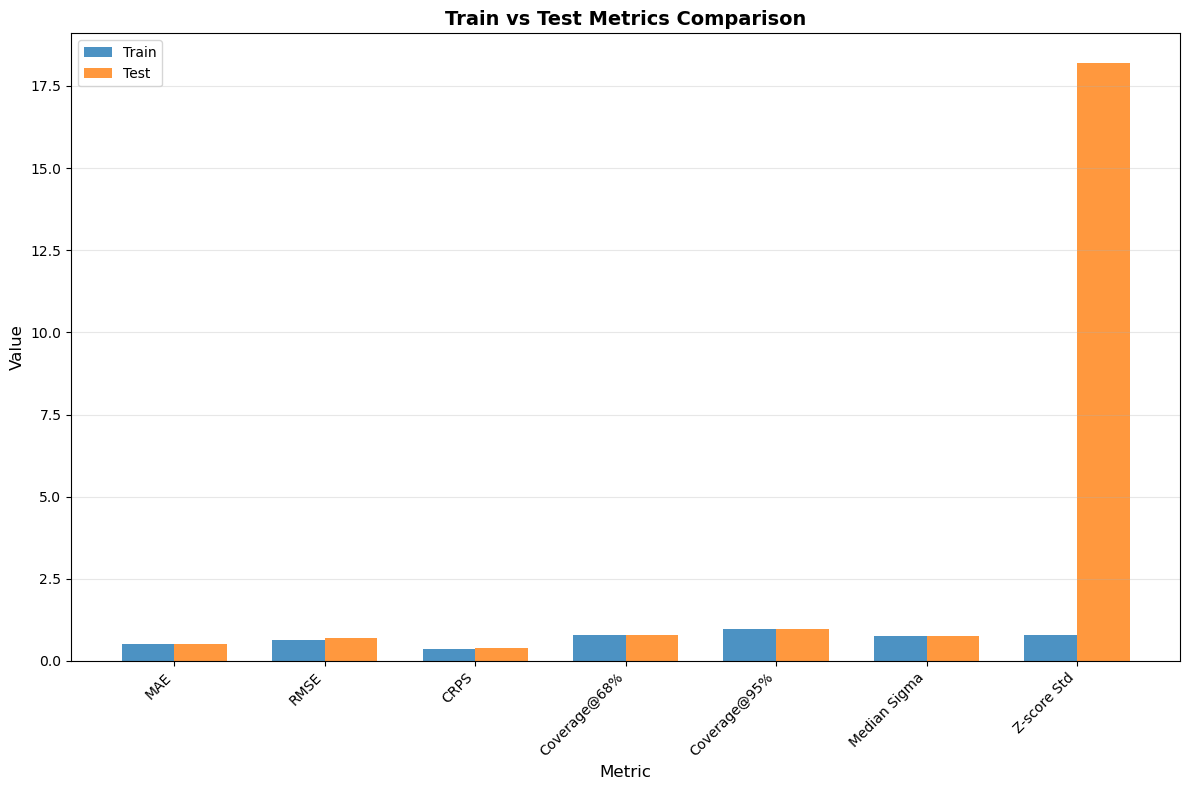

In [101]:
# Plot metrics comparison
fig, ax = plot_metrics_comparison(train_metrics, test_metrics)
plt.show()

# Core Performance Plots: Predicted vs True Age

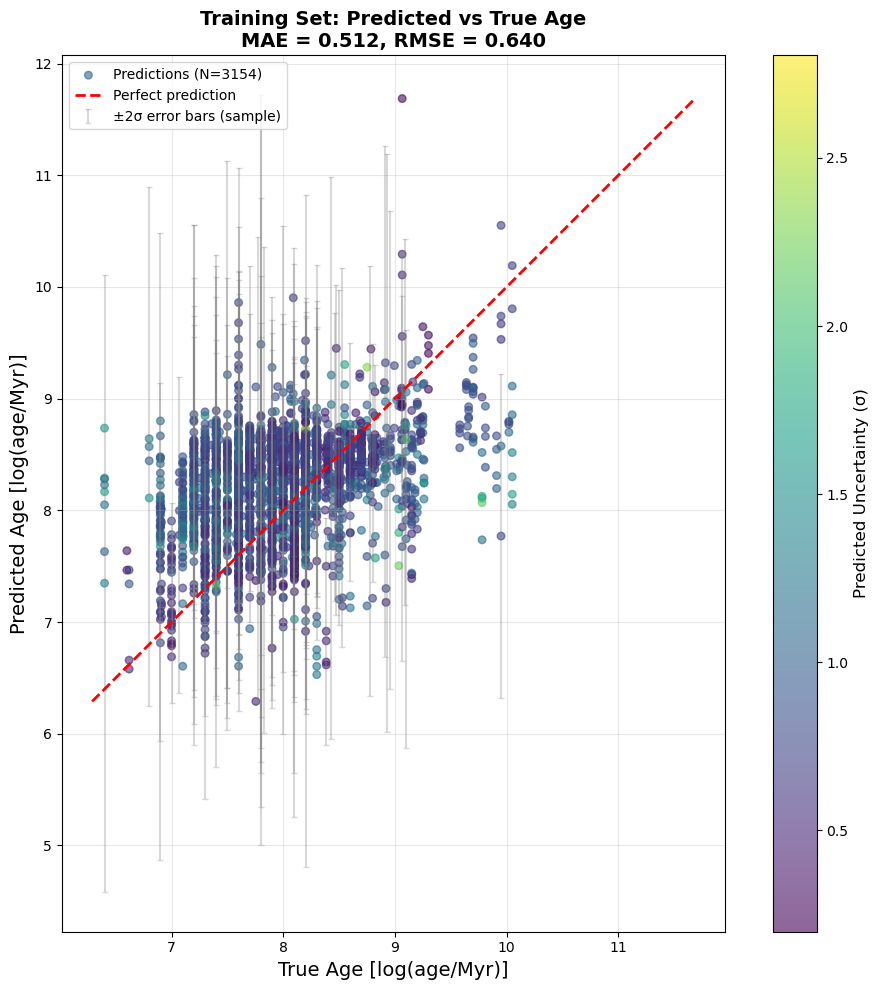

In [102]:
# ============================================================
# PREDICTED VS TRUE AGE - TRAINING SET
# ============================================================

fig, ax = plot_prediction_vs_truth(
    y_train, y_pred_train, sigma_pred_train,
    dataset_label='Training Set',
    show_errorbars=True,
    color_by_uncertainty=True,
    figsize=(10, 10)
)
plt.show()

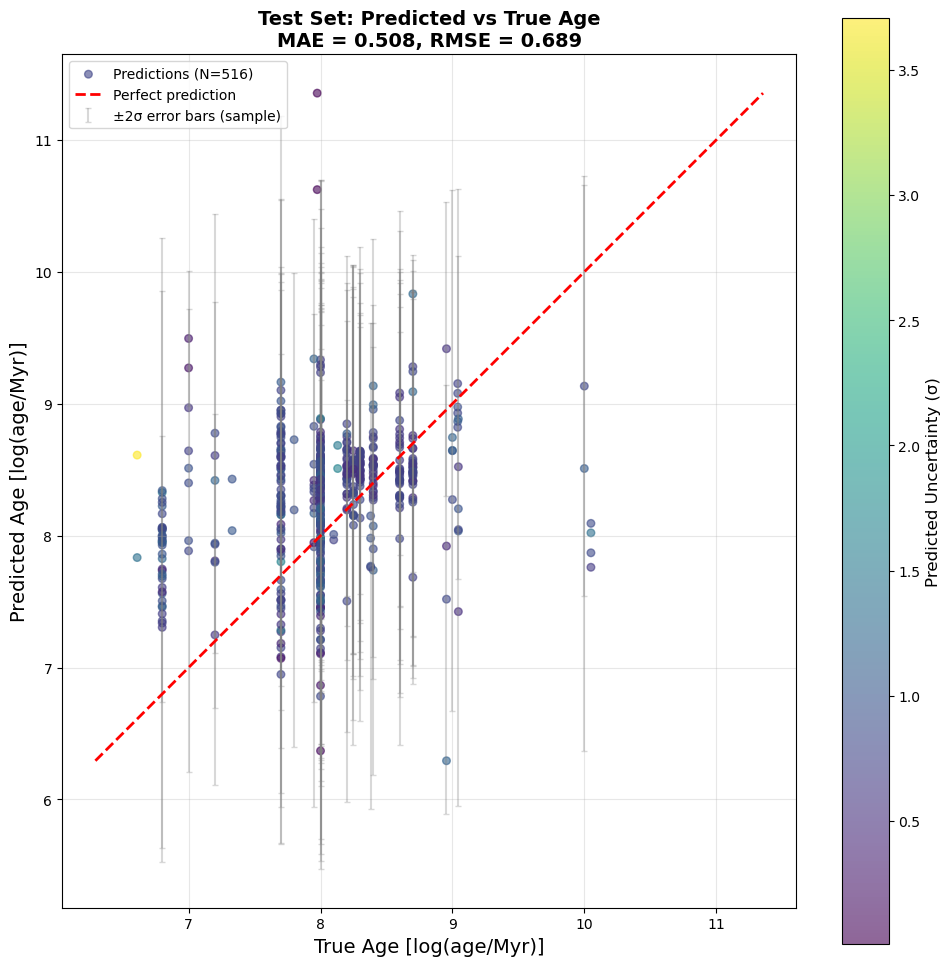

In [103]:
# ============================================================
# PREDICTED VS TRUE AGE - TEST SET
# ============================================================

fig, ax = plot_prediction_vs_truth(
    y_test, y_pred_test, sigma_pred_test,
    dataset_label='Test Set',
    show_errorbars=True,
    color_by_uncertainty=True,
    figsize=(10, 10)
)
plt.show()

# Residual Analysis

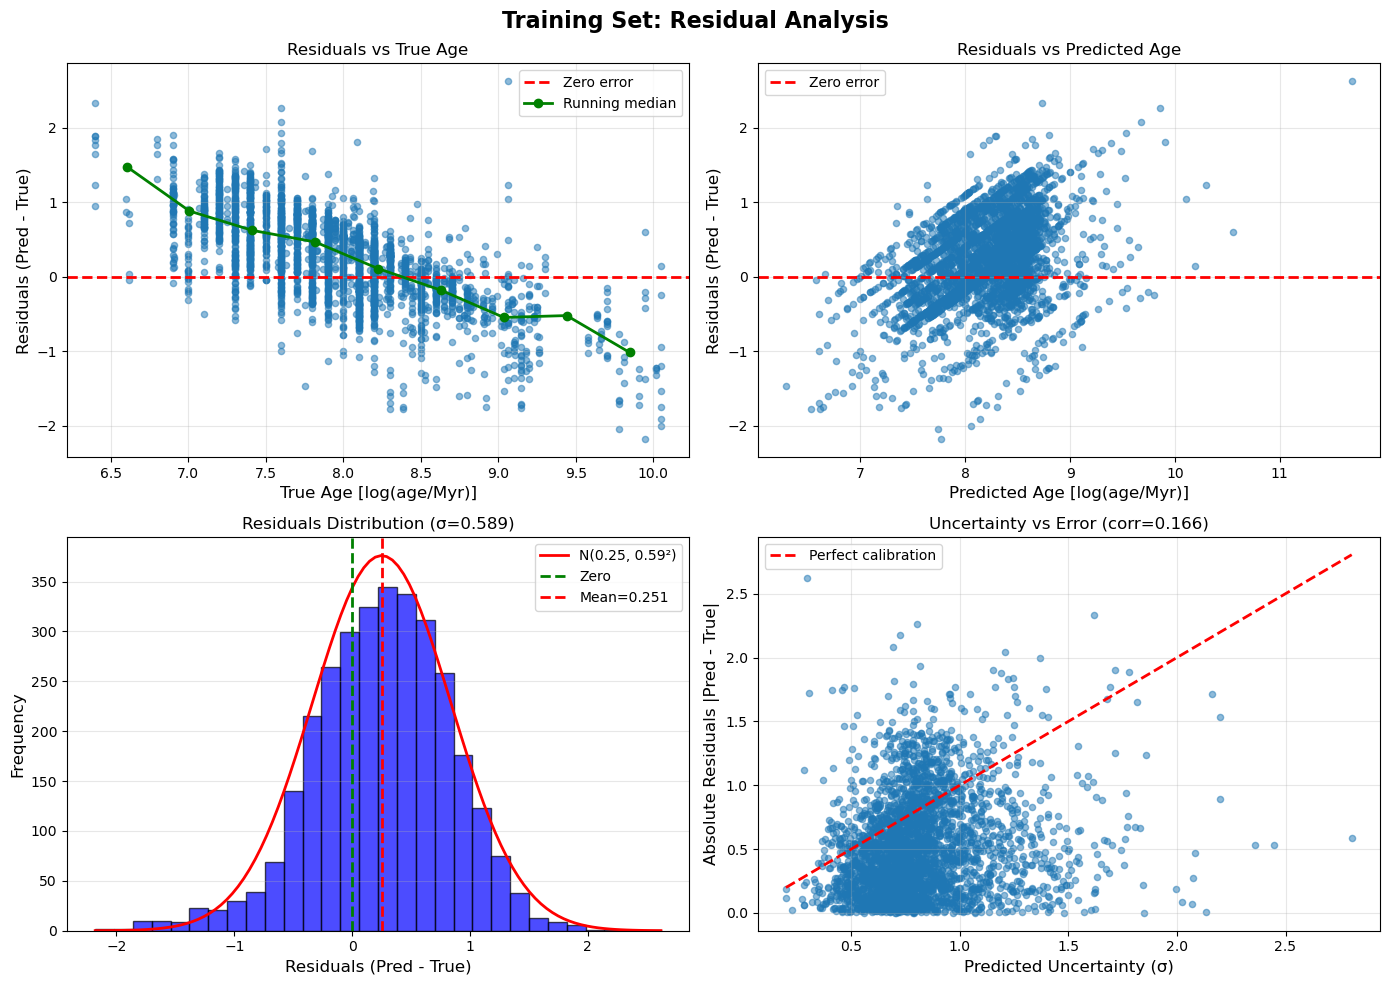

In [104]:
# ============================================================
# RESIDUAL ANALYSIS - TRAINING SET
# ============================================================

fig, axs = plot_residuals_analysis(
    y_train, y_pred_train, sigma_pred_train,
    dataset_label='Training Set'
)
plt.show()

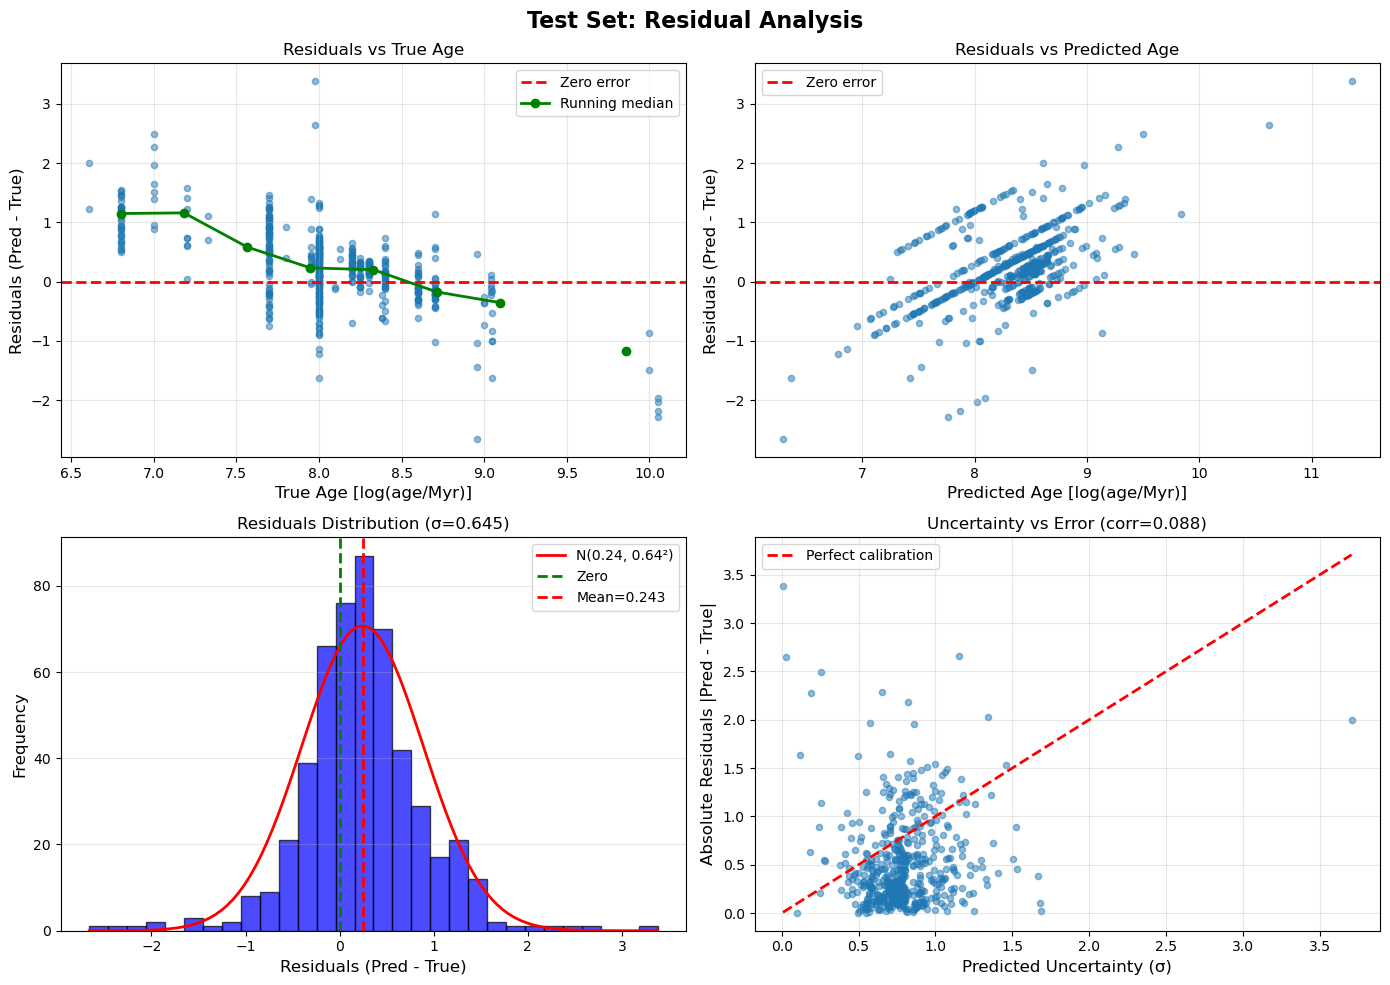

In [106]:
# ============================================================
# RESIDUAL ANALYSIS - TEST SET
# ============================================================

fig, axs = plot_residuals_analysis(
    y_test, y_pred_test, sigma_pred_test,
    dataset_label='Test Set'
)
plt.show()

# Uncertainty Calibration Analysis

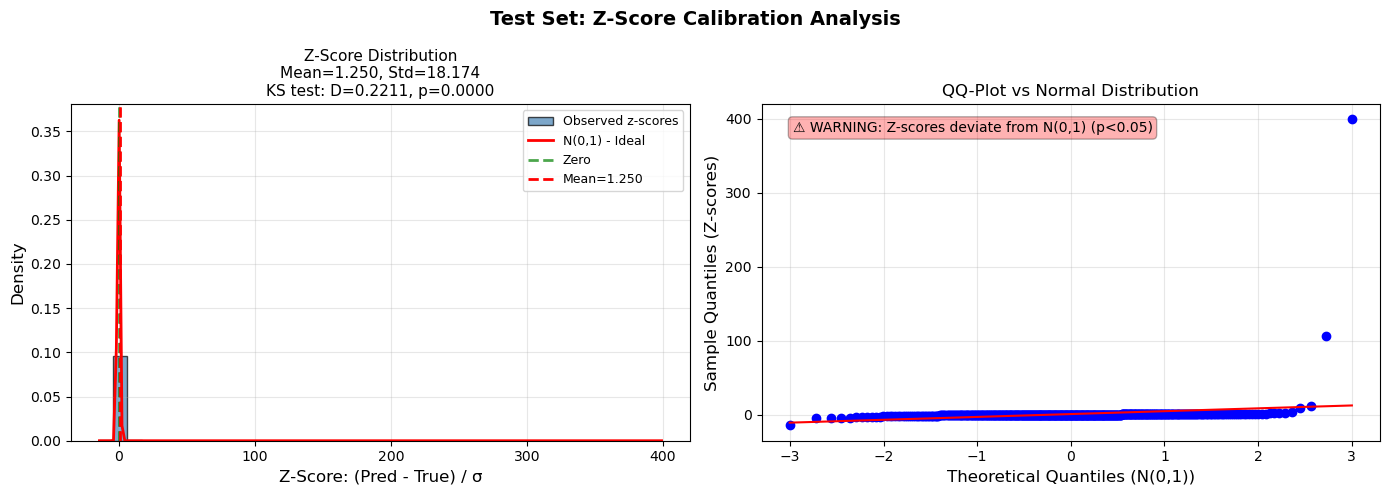


Z-Score Statistics:
  Mean: 1.2498 (ideal: 0)
  Std:  18.1742 (ideal: 1)
  KS test statistic: 0.2211
  KS test p-value:   0.0000
  ⚠️  Z-scores significantly deviate from N(0,1) (p < 0.05)


In [107]:
# ============================================================
# Z-SCORE ANALYSIS - TEST SET
# ============================================================

fig, axs, z_scores, ks_stat, ks_p = plot_zscore_analysis(
    y_test, y_pred_test, sigma_pred_test,
    dataset_label='Test Set'
)
plt.show()

print(f"\nZ-Score Statistics:")
print(f"  Mean: {z_scores.mean():.4f} (ideal: 0)")
print(f"  Std:  {z_scores.std():.4f} (ideal: 1)")
print(f"  KS test statistic: {ks_stat:.4f}")
print(f"  KS test p-value:   {ks_p:.4f}")
if ks_p > 0.05:
    print(f"  ✅ Cannot reject that z-scores are N(0,1) distributed (p > 0.05)")
else:
    print(f"  ⚠️  Z-scores significantly deviate from N(0,1) (p < 0.05)")

/astro/users/cgwill/TESS_Cluster_Age_ML/GaussianNN_CGW/Model_Pipeline/ModelEvaluation_PlottingFcns.py:45: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  color_by_uncertainty : bool


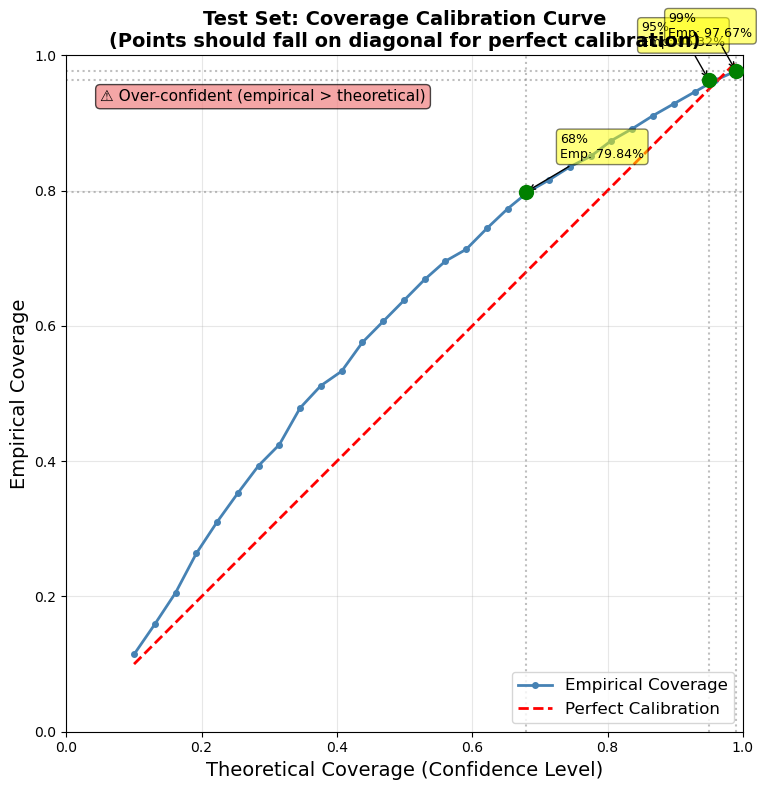


Coverage at Key Confidence Levels:
  50%: Empirical=63.76%, Error=+13.76%
  68%: Empirical=79.84%, Error=+11.84%
  95%: Empirical=96.32%, Error=+1.32%
  99%: Empirical=97.67%, Error=-1.33%


In [108]:
# ============================================================
# COVERAGE CALIBRATION CURVE - TEST SET
# ============================================================

fig, ax, coverage_dict = plot_coverage_calibration(
    y_test, y_pred_test, sigma_pred_test,
    dataset_label='Test Set'
)
plt.show()

print(f"\nCoverage at Key Confidence Levels:")
conf_levels = coverage_dict['confidence_levels']
emp_coverage = coverage_dict['empirical_coverage']
for level in [0.50, 0.68, 0.95, 0.99]:
    idx = np.argmin(np.abs(conf_levels - level))
    empirical = emp_coverage[idx]
    error = empirical - level
    print(f"  {level:.0%}: Empirical={empirical:.2%}, Error={error:+.2%}")

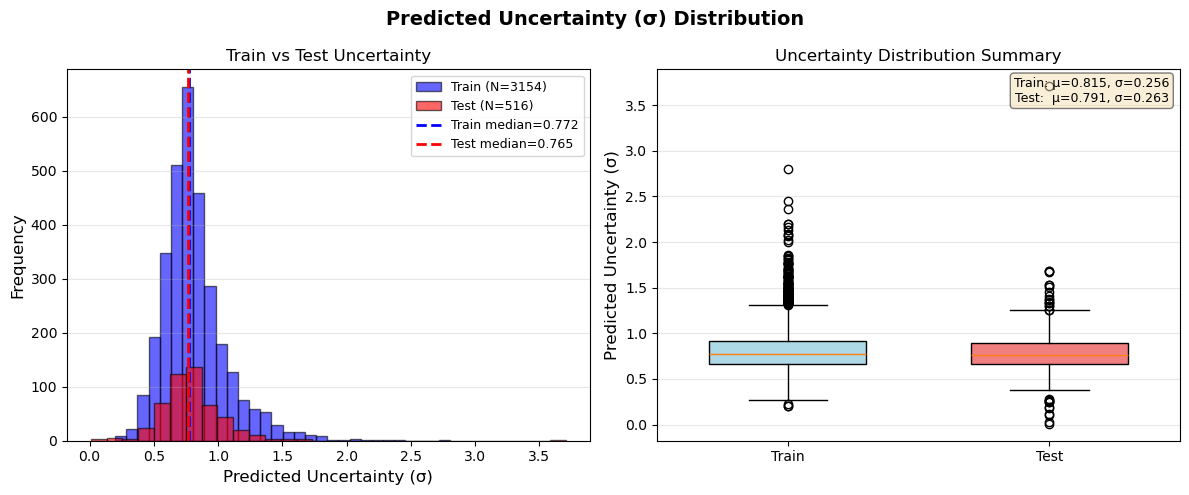

In [109]:
# ============================================================
# UNCERTAINTY DISTRIBUTION - TRAIN VS TEST
# ============================================================

fig, axs = plot_uncertainty_distribution(
    sigma_pred_train, sigma_pred_test
)
plt.show()

# MC Dropout Uncertainty Decomposition

Use Monte Carlo Dropout to decompose total uncertainty into **epistemic** (model uncertainty from limited training data) and **aleatoric** (irreducible data noise captured by the predicted sigma).

In [110]:
from ModelEvaluation_PlottingFcns import (
    mc_dropout_predict,
    plot_mc_dropout_predictions,
    plot_mc_epistemic_vs_aleatoric,
    plot_mc_uncertainty_decomposition
)

# Run MC Dropout sampling (100 stochastic forward passes)
mc_results = mc_dropout_predict(final_model, X_test_scaled, period_test_norm, num_samples=100)

# Shift MC mean predictions back to original scale
mc_results['mean_pred'] = mc_results['mean_pred'] + y_mean
mc_results['all_preds'] = mc_results['all_preds'] + y_mean

print("MC Dropout sampling complete!")
print(f"  Epistemic (MC std)  — mean: {mc_results['std_pred'].mean():.4f}, max: {mc_results['std_pred'].max():.4f}")
print(f"  Aleatoric (mean σ)  — mean: {mc_results['mean_sigma'].mean():.4f}, max: {mc_results['mean_sigma'].max():.4f}")
print(f"  Total uncertainty   — mean: {mc_results['total_uncertainty'].mean():.4f}")

MC Dropout sampling complete!
  Epistemic (MC std)  — mean: 0.2189, max: 3.1062
  Aleatoric (mean σ)  — mean: 0.8088, max: 3.7963
  Total uncertainty   — mean: 0.8599


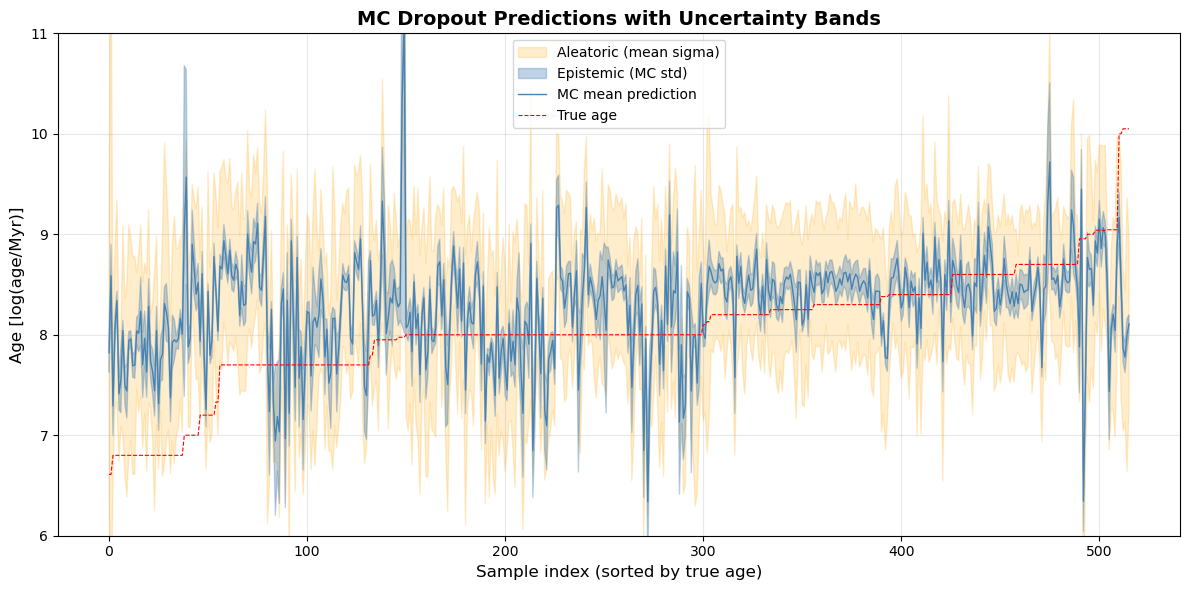

In [111]:
# MC Dropout Predictions with uncertainty bands
fig, ax = plot_mc_dropout_predictions(mc_results, y_test, sort_by_true=True)
plt.show()

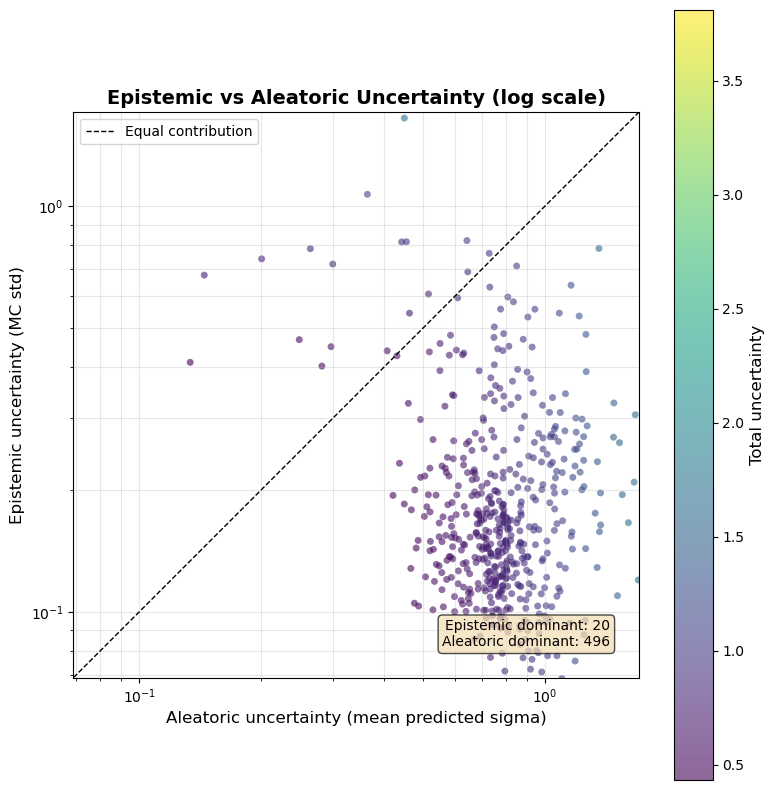

In [112]:
# Epistemic vs Aleatoric scatter
fig, ax = plot_mc_epistemic_vs_aleatoric(mc_results)
plt.show()

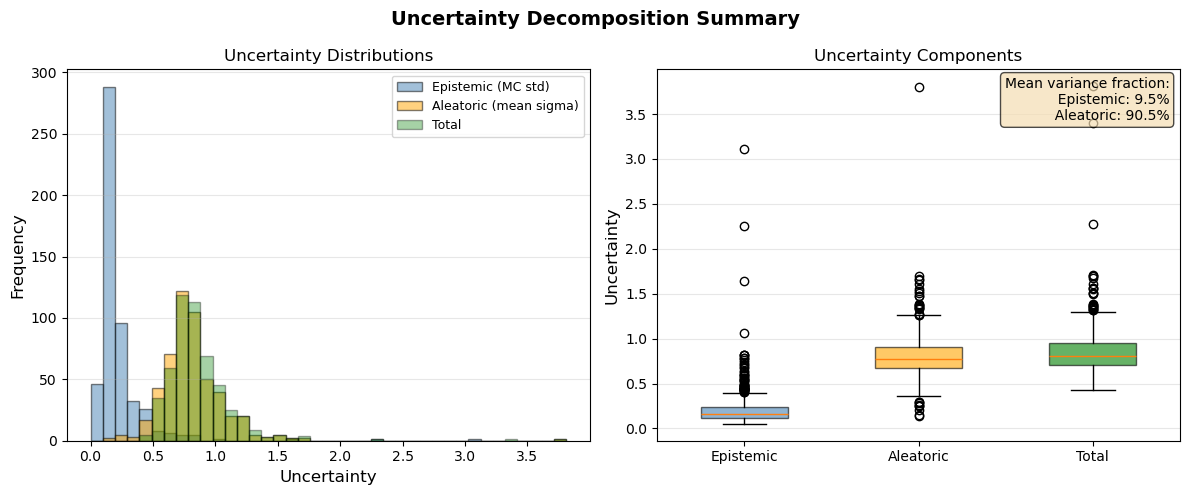

In [113]:
# Uncertainty decomposition summary
fig, axs = plot_mc_uncertainty_decomposition(mc_results)
plt.show()

# Next Steps: Performance Breakdown & Advanced Analysis (To Be Implemented)

The following evaluation plots remain to be added:

**Performance Breakdown Plots:**
- Error metrics by age bin (young/intermediate/old clusters) - MAE, RMSE across age ranges
- Coverage by age bin - Check if calibration holds uniformly across ages
- Performance by individual cluster - Identify best/worst predicted clusters

**Optional Advanced Analysis:**
- Feature importance via permutation - Which features drive predictions?